___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

# Concrete Slump Test Regression

The concrete slump test measures the consistency of fresh concrete before it sets. It is performed to check the workability of freshly made concrete, and therefore the ease with which concrete flows. It can also be used as an indicator of an improperly mixed batch.

<img src="https://i0.wp.com/civiconcepts.com/wp-content/uploads/2019/08/Slump-Cone-test-of-concrete.jpg?fit=977%2C488&ssl=1">

Our data set consists of various cement properties and the resulting slump test metrics in cm. Later on the set concrete is tested for its compressive strength 28 days later.

Input variables (9):

(component kg in one M^3 concrete)(7):
* Cement
* Slag
* Fly ash
* Water
* SP
* Coarse Aggr.
* Fine Aggr.

(Measurements)(2)
* SLUMP (cm)
* FLOW (cm)

Target variable (1):
* **28-day Compressive Strength (Mpa)**

Data Source: https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test

*Credit: Yeh, I-Cheng, "Modeling slump flow of concrete using second-order regressions and artificial neural networks," Cement and Concrete Composites, Vol.29, No. 6, 474-480, 2007.*

# Importing dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import skew

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import FeatureImportances

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

params = {
'figure.figsize':(12,6),
'figure.titlesize':20,
'font.size': 15,
'axes.titlesize': 20,
'axes.labelsize': 15,
'xtick.labelsize': 15,
'ytick.labelsize': 15,
'legend.fontsize': 15,
'boxplot.showmeans': True,
'boxplot.meanprops.marker': 'o',
'boxplot.meanprops.markeredgecolor': 'k',
'boxplot.meanprops.markerfacecolor': 'c',
'boxplot.meanprops.markersize': 10.1,
'boxplot.medianprops.color': 'r',
'boxplot.medianprops.linewidth': 2.0,
}
plt.rcParams.update(params)
# plt.rcParams.update(plt.rcParamsDefault)
sns.set_style("whitegrid")

# Environment settings: 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)
# Set it None to display all rows in the dataframe
pd.set_option('display.max_rows', 60)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV

# Loading data

In [3]:
df_origin = pd.read_csv('./cement_slump.csv')
df = df_origin
df.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.000,82.000,105.000,210.000,9.000,904.000,680.000,23.000,62.000,34.990
1,163.000,149.000,191.000,180.000,12.000,843.000,746.000,0.000,20.000,41.140
2,162.000,148.000,191.000,179.000,16.000,840.000,743.000,1.000,20.000,41.810
3,162.000,148.000,190.000,179.000,19.000,838.000,741.000,3.000,21.500,42.080
4,154.000,112.000,144.000,220.000,10.000,923.000,658.000,20.000,64.000,26.820


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Cement                              103 non-null    float64
 1   Slag                                103 non-null    float64
 2   Fly ash                             103 non-null    float64
 3   Water                               103 non-null    float64
 4   SP                                  103 non-null    float64
 5   Coarse Aggr.                        103 non-null    float64
 6   Fine Aggr.                          103 non-null    float64
 7   SLUMP(cm)                           103 non-null    float64
 8   FLOW(cm)                            103 non-null    float64
 9   Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,103.000,229.894,78.877,137.000,152.000,248.000,303.900,374.000
Slag,103.000,77.974,60.461,0.000,0.050,100.000,125.000,193.000
Fly ash,103.000,149.015,85.418,0.000,115.500,164.000,235.950,260.000
Water,103.000,197.168,20.208,160.000,180.000,196.000,209.500,240.000
SP,103.000,8.540,2.808,4.400,6.000,8.000,10.000,19.000
Coarse Aggr.,103.000,883.979,88.391,708.000,819.500,879.000,952.800,1049.900
Fine Aggr.,103.000,739.605,63.342,640.600,684.500,742.700,788.000,902.000
SLUMP(cm),103.000,18.049,8.751,0.000,14.500,21.500,24.000,29.000
FLOW(cm),103.000,49.611,17.569,20.000,38.500,54.000,63.750,78.000
Compressive Strength (28-day)(Mpa),103.000,36.039,7.837,17.190,30.900,35.520,41.205,58.530


# EDA and Graphical analysis

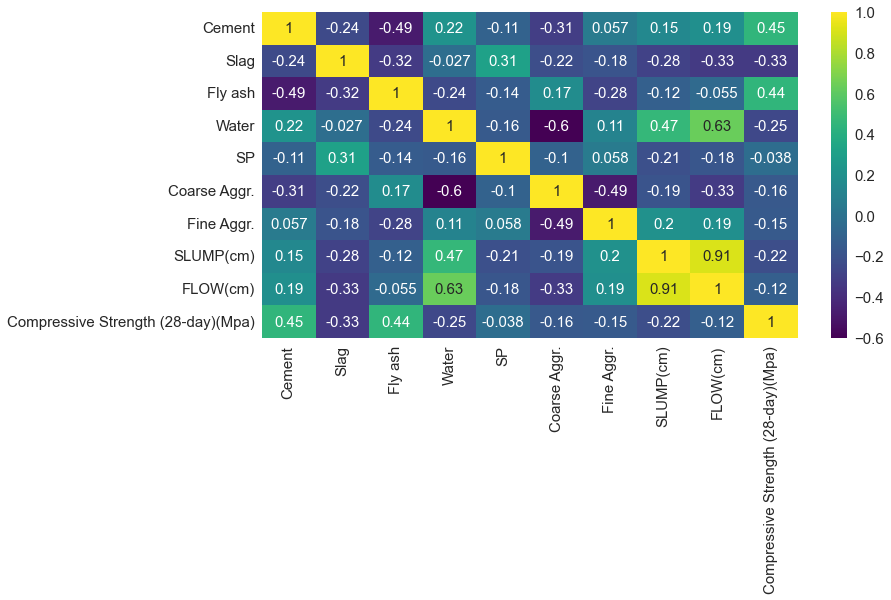

In [6]:
sns.heatmap(df.corr(), annot=True, cmap="viridis");

<Figure size 1080x2160 with 0 Axes>

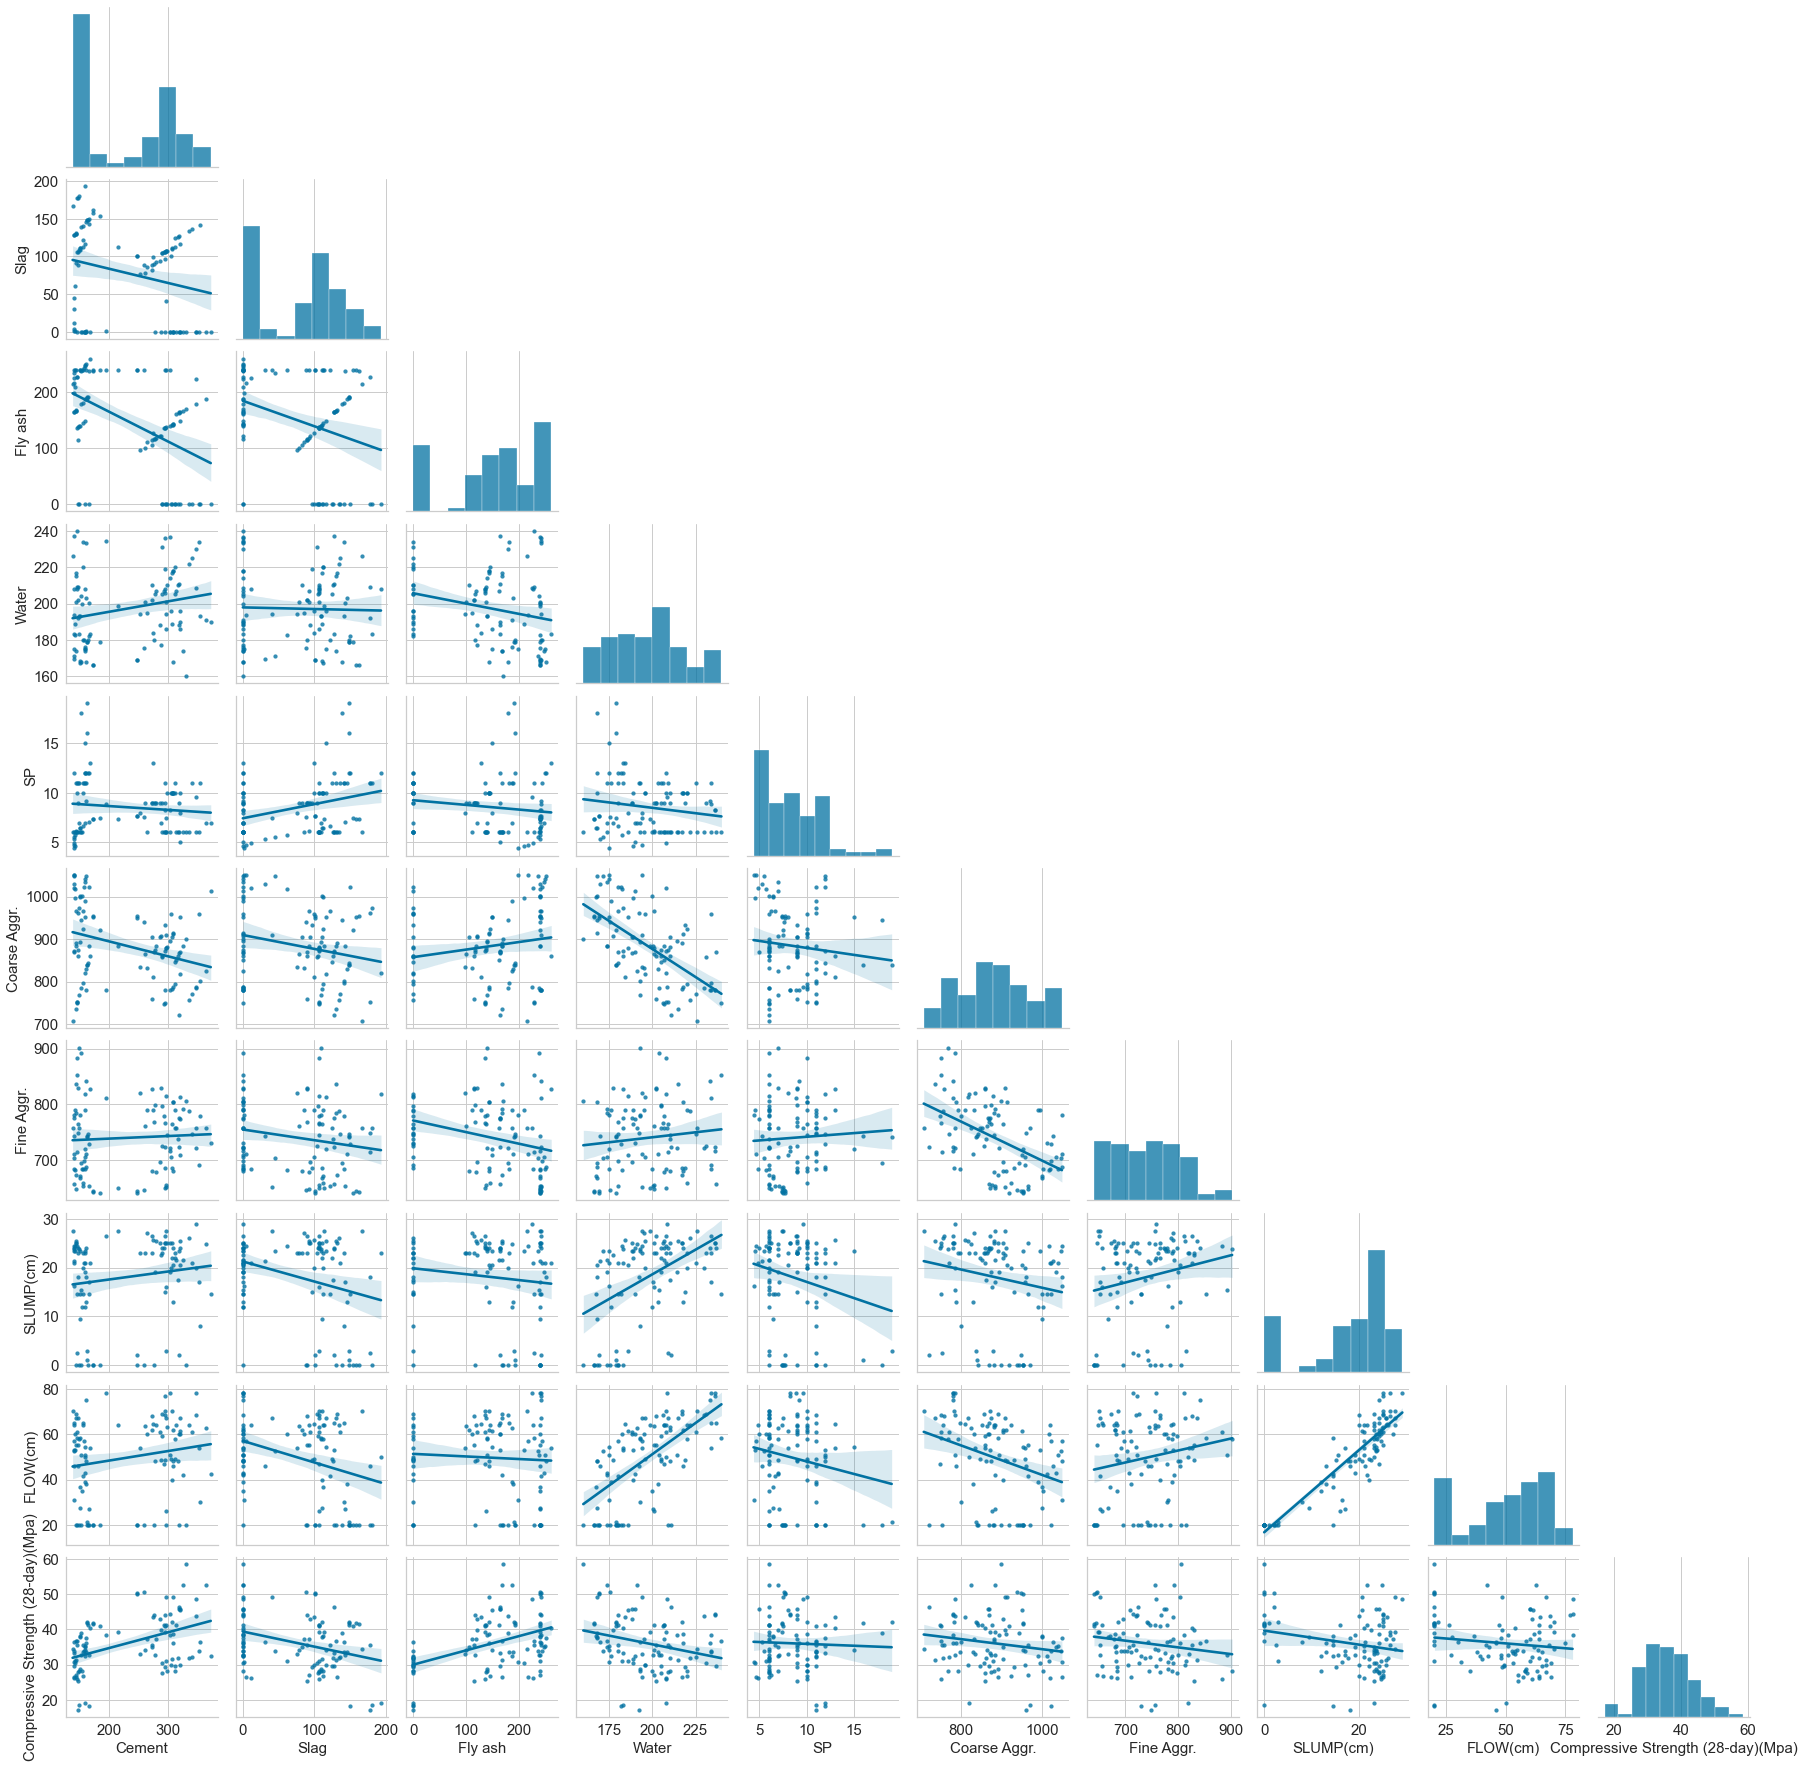

In [7]:
plt.figure(figsize=(15,30))
sns.pairplot(df, kind='reg', plot_kws={'scatter_kws':{'s':18}}, corner=True)

<AxesSubplot:>

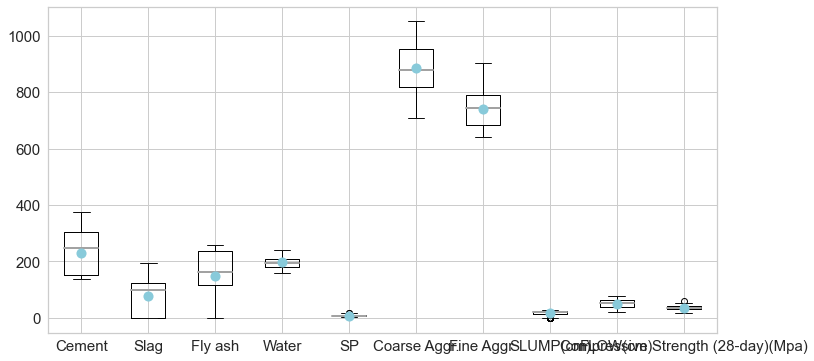

In [8]:
df.boxplot()

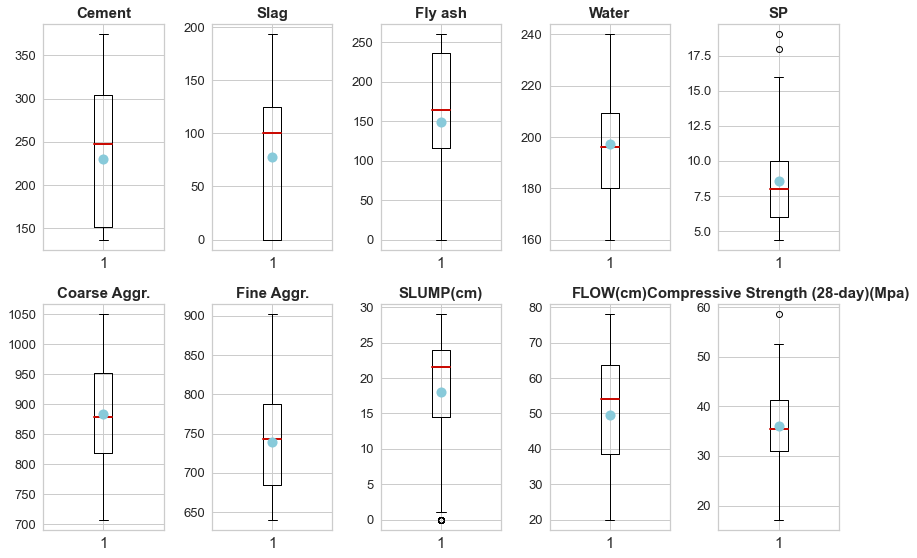

In [9]:
fig, axs = plt.subplots(int(np.ceil(len(df.columns)/5)), 5, figsize=(12,8))

for i, ax in enumerate(axs.flat):
    if i < len(df.columns):
        ax.boxplot(df.iloc[:,i])
        ax.set_title(df.columns[i], fontsize=15, fontweight='bold')
        ax.tick_params(axis='y', labelsize=13)

plt.tight_layout()

# Data Preprocessing 

## Features and target variable
* Split the data into features and target variable

In [10]:
X = df.drop(columns="Compressive Strength (28-day)(Mpa)")
y = df["Compressive Strength (28-day)(Mpa)"]

## Splitting data into training and testing
* Split the data into training and testing sets

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

## Scaling
* import StandardScaler and scale the data. Use fit_transform() on the training set and transform() on the testing set to prevent data leakage.

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled  = scaler.transform(X_test)

In [13]:
pd.DataFrame(X_train_scaled, columns=X.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,82.000,-0.000,1.006,-1.180,-0.990,0.020,0.933,1.820
Slag,82.000,0.000,1.006,-1.297,-1.295,0.361,0.800,1.871
Fly ash,82.000,0.000,1.006,-1.649,-0.377,0.208,1.037,1.191
Water,82.000,-0.000,1.006,-1.782,-0.840,-0.094,0.566,2.132
SP,82.000,0.000,1.006,-1.424,-0.874,-0.290,0.500,3.592
Coarse Aggr.,82.000,0.000,1.006,-2.054,-0.708,-0.084,0.738,1.839
Fine Aggr.,82.000,0.000,1.006,-1.583,-0.881,0.088,0.721,2.621
SLUMP(cm),82.000,-0.000,1.006,-1.960,-0.349,0.415,0.707,1.262
FLOW(cm),82.000,-0.000,1.006,-1.591,-0.918,0.189,0.837,1.661


In [14]:
pd.DataFrame(X_test_scaled, columns=X.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,21.000,-0.020,0.993,-1.136,-0.965,0.362,0.871,1.504
Slag,21.000,-0.084,0.958,-1.297,-1.297,0.164,0.541,1.609
Fly ash,21.000,0.214,0.816,-1.649,-0.104,0.248,0.930,1.305
Water,21.000,0.179,0.926,-1.390,-0.657,0.322,0.664,1.946
SP,21.000,-0.009,0.802,-1.355,-0.874,0.156,0.500,1.530
Coarse Aggr.,21.000,-0.248,1.007,-1.747,-1.200,-0.210,0.394,1.472
Fine Aggr.,21.000,0.046,1.092,-1.496,-0.853,-0.259,0.807,2.316
SLUMP(cm),21.000,0.223,0.826,-1.960,-0.016,0.596,0.818,0.985
FLOW(cm),21.000,0.340,0.868,-1.591,-0.021,0.652,0.876,1.605


##  Linear Regression
* Build a linear regression model, fit the model, and make predictions on the test and train set, and compare them.

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def train_val(y_train, y_train_pred, y_test, y_pred, name):
    
    scores = {name+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    name+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [16]:
def check_pred_data_describe(y_pred, y_test):
    pred = pd.DataFrame(y_pred, columns=['y_pred']).describe().T
    test = pd.DataFrame(y_test).describe().T
    residual = pd.DataFrame(y_pred -y_test).set_axis(["Residual"], axis="columns").describe().T
    return pd.concat([pred, test,residual])

In [17]:
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression()
model_linear.fit(X_train_scaled, y_train)
y_pred = model_linear.predict(X_test_scaled)
y_train_pred = model_linear.predict(X_train_scaled)
train_val(y_train, y_train_pred, y_test, y_pred, "linear")

,linear_train,linear_test
R2,0.907,0.912
mae,1.936,1.740
mse,5.874,4.454
rmse,2.424,2.111


In [18]:
check_pred_data_describe(y_pred, y_test)

,count,mean,std,min,25%,50%,75%,max
y_pred,21.000,37.133,6.737,27.054,30.865,37.359,42.560,49.008
Compressive Strength (28-day)(Mpa),21.000,36.787,7.289,26.020,31.370,35.520,43.010,50.500
Residual,21.000,0.347,2.133,-4.626,-0.905,0.480,1.839,3.372


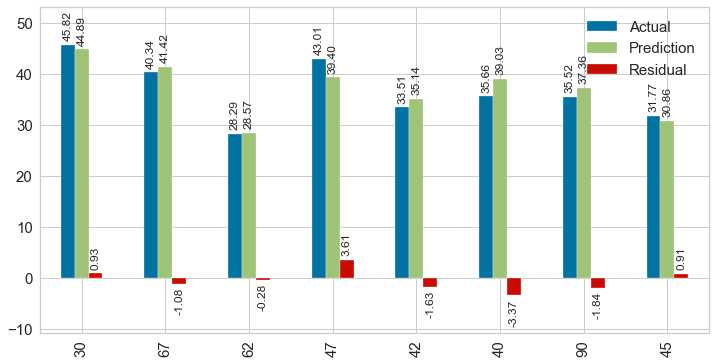

In [19]:
comparing = pd.DataFrame({"Actual": y_test, "Prediction": y_pred, "Residual":y_test-y_pred})
g = comparing.head(8).plot.bar()
# annotate
for i in g.containers:
    g.bar_label(i, fmt='%.2f', fontsize=12, rotation=90, padding=4)
# pad the spacing between the number and the edge of the figure
g.margins(y=0.15) 

#tick_params(xaxis.set_tick_params) rotation or labelrotation
#g.tick_params(axis='x', labelrotation=0)

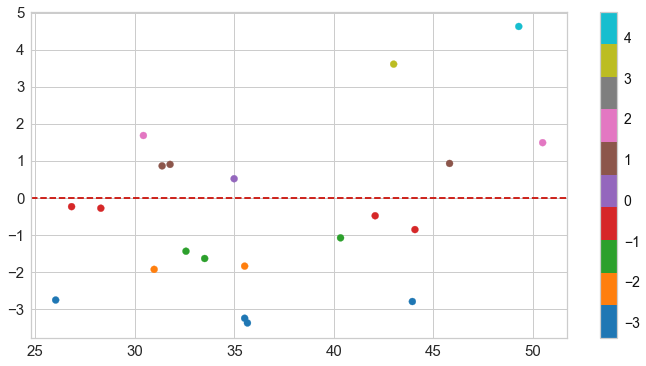

In [20]:
# Residuals scatterplot
plt.scatter(x=y_test, y='Residual', data=comparing, c=comparing['Residual'], cmap= 'tab10') 
plt.axhline(y = 0, color ="r", linestyle = "--")
# colorbar tick_params
plt.colorbar().ax.tick_params(axis='both', labelsize=14, colors='k')

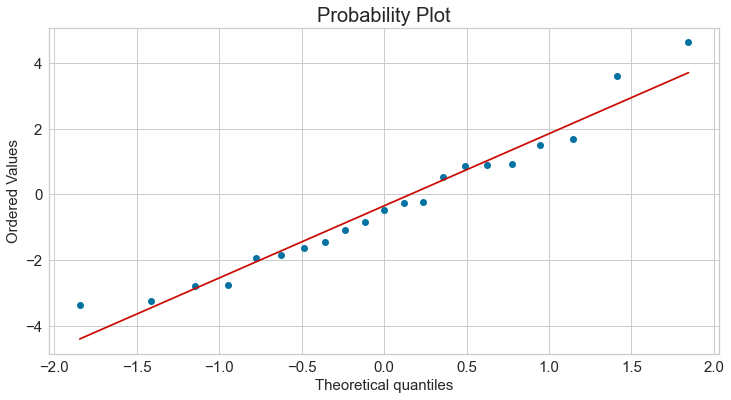

In [21]:
stats.probplot(comparing['Residual'], dist ="norm", plot =plt);

In [22]:
skew(comparing['Residual'])

0.6026499074920305

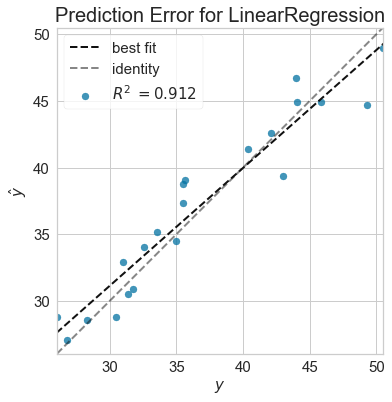

In [23]:
model = LinearRegression()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(); 

In [24]:
linear_coef = pd.DataFrame(model_linear.coef_, index=X.columns).set_axis(["Linear"], axis="columns")
linear_coef

,Linear
Cement,4.280
Slag,-2.223
Fly ash,3.932
Water,-4.771
SP,0.121
Coarse Aggr.,-5.277
Fine Aggr.,-2.611
SLUMP(cm),-2.188
FLOW(cm),1.466


In [25]:
train_val(y_train, y_train_pred, y_test, y_pred, "linear")

,linear_train,linear_test
R2,0.907,0.912
mae,1.936,1.740
mse,5.874,4.454
rmse,2.424,2.111


In [26]:
comparison = train_val(y_train, y_train_pred, y_test, y_pred, "linear")

## Cross Validation

In [27]:
from sklearn.model_selection import cross_validate
model_cross = cross_validate(LinearRegression(), X_train_scaled, y_train, 
        scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', 'neg_root_mean_squared_error'], cv = 10)
scores = pd.DataFrame(model_cross).iloc[:,2:].mean()
scores

test_r2                             0.826
test_neg_mean_absolute_error       -2.251
test_neg_mean_squared_error        -7.923
test_neg_root_mean_squared_error   -2.721
dtype: float64

# Regularization
* Regularize the model by adding a regularization term to the loss function.

## Ridge - Ridge&Cross - RidgeCV

### Ridge

In [28]:
from sklearn.linear_model import Ridge
model_ridge = Ridge(alpha=1,random_state=42)
model_ridge.fit(X_train_scaled,y_train)
y_pred = model_ridge.predict(X_test_scaled)
y_train_pred = model_ridge.predict(X_train_scaled)
train_val(y_train, y_train_pred, y_test, y_pred, "ridge")

,ridge_train,ridge_test
R2,0.906,0.911
mae,1.938,1.732
mse,5.922,4.493
rmse,2.434,2.120


In [29]:
check_pred_data_describe(y_pred, y_test)

,count,mean,std,min,25%,50%,75%,max
y_pred,21.000,37.068,6.616,26.982,30.936,37.343,42.230,48.870
Compressive Strength (28-day)(Mpa),21.000,36.787,7.289,26.020,31.370,35.520,43.010,50.500
Residual,21.000,0.281,2.153,-4.803,-1.004,0.402,1.823,3.327


In [30]:
comparison = pd.concat([comparison,train_val(y_train, y_train_pred, y_test, y_pred, "ridge")], axis=1)
comparison

,linear_train,linear_test,ridge_train,ridge_test
R2,0.907,0.912,0.906,0.911
mae,1.936,1.740,1.938,1.732
mse,5.874,4.454,5.922,4.493
rmse,2.424,2.111,2.434,2.120


### Ridge & Cross Validation

In [31]:
from sklearn.model_selection import cross_validate
model_crossridge = cross_validate(Ridge(alpha=1, random_state=42), X_train_scaled, y_train, 
        scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', 'neg_root_mean_squared_error'], cv = 10)
scores = pd.DataFrame(model_crossridge).iloc[:,2:].mean()
scores

test_r2                             0.829
test_neg_mean_absolute_error       -2.222
test_neg_mean_squared_error        -7.829
test_neg_root_mean_squared_error   -2.696
dtype: float64

### RidgeCv

In [32]:
from sklearn.linear_model import RidgeCV
alpha = np.linspace(0.1,5,50)
model_ridgecv = RidgeCV(alphas=alpha,cv = 10, scoring= "neg_root_mean_squared_error")
model_ridgecv.fit(X_train_scaled,y_train)
y_pred = model_ridgecv.predict(X_test_scaled)
y_train_pred = model_ridgecv.predict(X_train_scaled)
train_val(y_train, y_train_pred, y_test, y_pred, "ridge")

,ridge_train,ridge_test
R2,0.906,0.911
mae,1.938,1.732
mse,5.915,4.484
rmse,2.432,2.117


In [33]:
model_ridgecv.alpha_

0.9

In [34]:
model_ridgecv.best_score_

-2.696398340329338

In [35]:
check_pred_data_describe(y_pred, y_test)

,count,mean,std,min,25%,50%,75%,max
y_pred,21.000,37.073,6.627,26.976,30.930,37.350,42.255,48.892
Compressive Strength (28-day)(Mpa),21.000,36.787,7.289,26.020,31.370,35.520,43.010,50.500
Residual,21.000,0.286,2.150,-4.787,-1.001,0.394,1.830,3.324


In [36]:
comparison = pd.concat([comparison,train_val(y_train, y_train_pred, y_test, y_pred, "ridge_cv")], axis=1)
comparison

,linear_train,linear_test,ridge_train,ridge_test,ridge_cv_train,ridge_cv_test
R2,0.907,0.912,0.906,0.911,0.906,0.911
mae,1.936,1.740,1.938,1.732,1.938,1.732
mse,5.874,4.454,5.922,4.493,5.915,4.484
rmse,2.424,2.111,2.434,2.120,2.432,2.117


In [37]:
ridgecv_coef = pd.DataFrame(model_ridgecv.coef_, index=X.columns).set_axis(["RidgeCv"], axis="columns")
ridgecv_coef

,RidgeCv
Cement,5.004
Slag,-1.392
Fly ash,4.794
Water,-3.938
SP,0.257
Coarse Aggr.,-4.098
Fine Aggr.,-1.767
SLUMP(cm),-1.973
FLOW(cm),1.160


In [38]:
comparison_coef = pd.concat([linear_coef ,ridgecv_coef], axis=1)
comparison_coef

,Linear,RidgeCv
Cement,4.280,5.004
Slag,-2.223,-1.392
Fly ash,3.932,4.794
Water,-4.771,-3.938
SP,0.121,0.257
Coarse Aggr.,-5.277,-4.098
Fine Aggr.,-2.611,-1.767
SLUMP(cm),-2.188,-1.973
FLOW(cm),1.466,1.160


## Lasso - Lasso&CrossValidation - LassoCv
* Build a Lasso regression model, fit the model, and make predictions on the test and train set, and compare them.

### Lasso

In [39]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=1, max_iter=1000, random_state=42)
model_lasso.fit(X_train_scaled,y_train)
y_pred = model_lasso.predict(X_test_scaled)
y_train_pred = model_lasso.predict(X_train_scaled)
train_val(y_train, y_train_pred, y_test, y_pred, "lasso")

,lasso_train,lasso_test
R2,0.776,0.802
mae,2.960,2.466
mse,14.144,10.036
rmse,3.761,3.168


In [40]:
check_pred_data_describe(y_pred, y_test)

,count,mean,std,min,25%,50%,75%,max
y_pred,21.000,36.579,4.643,29.681,33.386,36.420,39.435,44.866
Compressive Strength (28-day)(Mpa),21.000,36.787,7.289,26.020,31.370,35.520,43.010,50.500
Residual,21.000,-0.208,3.239,-7.891,-1.655,0.760,2.107,4.097


In [41]:
comparison = pd.concat([comparison,train_val(y_train, y_train_pred, y_test, y_pred, "lasso")], axis=1)
comparison

,linear_train,linear_test,ridge_train,ridge_test,ridge_cv_train,ridge_cv_test,lasso_train,lasso_test
R2,0.907,0.912,0.906,0.911,0.906,0.911,0.776,0.802
mae,1.936,1.740,1.938,1.732,1.938,1.732,2.960,2.466
mse,5.874,4.454,5.922,4.493,5.915,4.484,14.144,10.036
rmse,2.424,2.111,2.434,2.120,2.432,2.117,3.761,3.168


### Lasso&Cross Validation

In [42]:
from sklearn.model_selection import cross_validate
model_crosslasso = cross_validate(Lasso(alpha=1,random_state=42), X_train_scaled, y_train, 
        scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', 'neg_root_mean_squared_error'], cv = 10)
scores = pd.DataFrame(model_crosslasso).iloc[:,2:].mean()
scores

test_r2                              0.659
test_neg_mean_absolute_error        -3.220
test_neg_mean_squared_error        -17.123
test_neg_root_mean_squared_error    -3.995
dtype: float64

### LassoCv

In [43]:
from sklearn.linear_model import LassoCV
alpha = np.linspace(0.01,1,100)
model_lassocv = LassoCV(alphas=alpha,cv = 10, max_iter=100000,random_state=42)
model_lassocv.fit(X_train_scaled,y_train)
y_pred = model_lassocv.predict(X_test_scaled)
y_train_pred = model_lassocv.predict(X_train_scaled)
train_val(y_train, y_train_pred, y_test, y_pred, "lasso_cv")

,lasso_cv_train,lasso_cv_test
R2,0.907,0.913
mae,1.936,1.721
mse,5.898,4.413
rmse,2.429,2.101


In [44]:
model_lassocv.alpha_

0.01

In [45]:
check_pred_data_describe(y_pred, y_test)

,count,mean,std,min,25%,50%,75%,max
y_pred,21.000,37.100,6.707,26.836,30.904,37.437,42.389,49.081
Compressive Strength (28-day)(Mpa),21.000,36.787,7.289,26.020,31.370,35.520,43.010,50.500
Residual,21.000,0.313,2.129,-4.674,-1.000,0.343,1.917,3.282


In [46]:
comparison = pd.concat([comparison,train_val(y_train, y_train_pred, y_test, y_pred, "lasso_cv")], axis=1)
comparison

,linear_train,linear_test,ridge_train,ridge_test,ridge_cv_train,ridge_cv_test,lasso_train,lasso_test,lasso_cv_train,lasso_cv_test
R2,0.907,0.912,0.906,0.911,0.906,0.911,0.776,0.802,0.907,0.913
mae,1.936,1.740,1.938,1.732,1.938,1.732,2.960,2.466,1.936,1.721
mse,5.874,4.454,5.922,4.493,5.915,4.484,14.144,10.036,5.898,4.413
rmse,2.424,2.111,2.434,2.120,2.432,2.117,3.761,3.168,2.429,2.101


In [47]:
lassocv_coef = pd.DataFrame(model_lassocv.coef_, index=X.columns).set_axis(["LassoCv"], axis="columns")
lassocv_coef

,LassoCv
Cement,5.243
Slag,-1.185
Fly ash,5.041
Water,-3.920
SP,0.260
Coarse Aggr.,-3.945
Fine Aggr.,-1.624
SLUMP(cm),-2.047
FLOW(cm),1.280


In [48]:
comparison_coef = pd.concat([comparison_coef ,lassocv_coef], axis=1)
comparison_coef

,Linear,RidgeCv,LassoCv
Cement,4.280,5.004,5.243
Slag,-2.223,-1.392,-1.185
Fly ash,3.932,4.794,5.041
Water,-4.771,-3.938,-3.920
SP,0.121,0.257,0.260
Coarse Aggr.,-5.277,-4.098,-3.945
Fine Aggr.,-2.611,-1.767,-1.624
SLUMP(cm),-2.188,-1.973,-2.047
FLOW(cm),1.466,1.160,1.280


## Elastic-Net - Elastic-Net&Cross Validation - Elastic-NetCV

---

* Build an Elastic-Net regression model, fit the model, and make predictions on the test and train set, and compare them.
* Use Gridsearch for hyperparameter tuning instead of ElacticnetCV

### Elastic- Net

In [49]:
from sklearn.linear_model import ElasticNet
model_elastic = ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000, random_state=42)
model_elastic.fit(X_train_scaled,y_train)
y_pred = model_elastic.predict(X_test_scaled)
y_train_pred = model_elastic.predict(X_train_scaled)
train_val(y_train, y_train_pred, y_test, y_pred, "elasticnet")

,elasticnet_train,elasticnet_test
R2,0.637,0.635
mae,3.803,3.556
mse,22.982,18.466
rmse,4.794,4.297


In [50]:
check_pred_data_describe(y_pred, y_test)

,count,mean,std,min,25%,50%,75%,max
y_pred,21.000,36.303,3.206,31.250,34.011,36.380,38.567,42.226
Compressive Strength (28-day)(Mpa),21.000,36.787,7.289,26.020,31.370,35.520,43.010,50.500
Residual,21.000,-0.484,4.375,-9.196,-3.752,0.880,3.248,6.167


In [51]:
comparison = pd.concat([comparison,train_val(y_train, y_train_pred, y_test, y_pred, "elasticnet")], axis=1)
comparison

,linear_train,linear_test,ridge_train,ridge_test,ridge_cv_train,ridge_cv_test,lasso_train,lasso_test,lasso_cv_train,lasso_cv_test,elasticnet_train,elasticnet_test
R2,0.907,0.912,0.906,0.911,0.906,0.911,0.776,0.802,0.907,0.913,0.637,0.635
mae,1.936,1.740,1.938,1.732,1.938,1.732,2.960,2.466,1.936,1.721,3.803,3.556
mse,5.874,4.454,5.922,4.493,5.915,4.484,14.144,10.036,5.898,4.413,22.982,18.466
rmse,2.424,2.111,2.434,2.120,2.432,2.117,3.761,3.168,2.429,2.101,4.794,4.297


### Elastic-Net&Cross Validation

In [52]:
from sklearn.model_selection import cross_validate
model_crossridge = cross_validate(ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=10000, random_state=42), X_train_scaled, y_train, 
        scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', 'neg_root_mean_squared_error'], cv = 10)
scores = pd.DataFrame(model_cross).iloc[:,2:].mean()
scores

test_r2                             0.826
test_neg_mean_absolute_error       -2.251
test_neg_mean_squared_error        -7.923
test_neg_root_mean_squared_error   -2.721
dtype: float64

### ElasticNetCV

In [53]:
from sklearn.linear_model import ElasticNetCV
alpha = np.linspace(0.01,1,100)
l1ratioo = np.linspace(0,1,10)
model_elasticnet_cv = ElasticNetCV(alphas=alpha,cv = 10, max_iter=10000,random_state=42, l1_ratio=l1ratioo)
model_elasticnet_cv.fit(X_train_scaled,y_train)
y_pred = model_elasticnet_cv.predict(X_test_scaled)
y_train_pred = model_elasticnet_cv.predict(X_train_scaled)
train_val(y_train, y_train_pred, y_test, y_pred, "elasticnet_cv")

,elasticnet_cv_train,elasticnet_cv_test
R2,0.907,0.912
mae,1.937,1.732
mse,5.911,4.476
rmse,2.431,2.116


In [54]:
model_elasticnet_cv.alpha_

0.01

In [55]:
model_elasticnet_cv.l1_ratio_

0.0

In [56]:
comparison = pd.concat([comparison,train_val(y_train, y_train_pred, y_test, y_pred, "elasticnet_cv")], axis=1)
comparison

,linear_train,linear_test,ridge_train,ridge_test,ridge_cv_train,ridge_cv_test,lasso_train,lasso_test,lasso_cv_train,lasso_cv_test,elasticnet_train,elasticnet_test,elasticnet_cv_train,elasticnet_cv_test
R2,0.907,0.912,0.906,0.911,0.906,0.911,0.776,0.802,0.907,0.913,0.637,0.635,0.907,0.912
mae,1.936,1.740,1.938,1.732,1.938,1.732,2.960,2.466,1.936,1.721,3.803,3.556,1.937,1.732
mse,5.874,4.454,5.922,4.493,5.915,4.484,14.144,10.036,5.898,4.413,22.982,18.466,5.911,4.476
rmse,2.424,2.111,2.434,2.120,2.432,2.117,3.761,3.168,2.429,2.101,4.794,4.297,2.431,2.116


In [57]:
elasticnet_cv_coef = pd.DataFrame(model_elasticnet_cv.coef_, index=X.columns).set_axis(["ElasticNetCV"], axis="columns")
elasticnet_cv_coef

,ElasticNetCV
Cement,4.995
Slag,-1.407
Fly ash,4.781
Water,-3.965
SP,0.254
Coarse Aggr.,-4.127
Fine Aggr.,-1.786
SLUMP(cm),-1.989
FLOW(cm),1.182


In [58]:
comparison_coef = pd.concat([comparison_coef ,elasticnet_cv_coef], axis=1)
comparison_coef

,Linear,RidgeCv,LassoCv,ElasticNetCV
Cement,4.280,5.004,5.243,4.995
Slag,-2.223,-1.392,-1.185,-1.407
Fly ash,3.932,4.794,5.041,4.781
Water,-4.771,-3.938,-3.920,-3.965
SP,0.121,0.257,0.260,0.254
Coarse Aggr.,-5.277,-4.098,-3.945,-4.127
Fine Aggr.,-2.611,-1.767,-1.624,-1.786
SLUMP(cm),-2.188,-1.973,-2.047,-1.989
FLOW(cm),1.466,1.160,1.280,1.182


## Grid Search

In [59]:
alpha = np.linspace(0.01,1,100)

In [60]:
ratio_space = np.concatenate((np.linspace(0.1, 0.2, 3), np.arange(0.3, 0.8, 0.2), np.linspace(0.9, 1, 3)))
ratio_space

array([0.1 , 0.15, 0.2 , 0.3 , 0.5 , 0.7 , 0.9 , 0.95, 1.  ])

In [61]:
from sklearn.model_selection import GridSearchCV
elastic_model = ElasticNet(max_iter=10000, random_state=42)
param_grid = {"alpha":alpha,
            "l1_ratio":ratio_space}
grid_model = GridSearchCV(estimator = elastic_model, param_grid = param_grid, 
                          scoring = 'neg_root_mean_squared_error', cv =10, verbose =2)
grid_model.fit(X_train, y_train)
y_pred = grid_model.predict(X_test)
y_train_pred = grid_model.predict(X_train)
train_val(y_train, y_train_pred, y_test, y_pred, "GridSearch")

Fitting 10 folds for each of 900 candidates, totalling 9000 fits
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........alpha=0.01, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.01, l1_ratio=0.1

[CV] END ...........alpha=0.02, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.02, l1_ratio=0.3; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.03, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.03, l1_ratio=0.5; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.04, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.04, l1_ratio=0.9; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.05, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.05, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.05, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.05, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.05, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.05, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.05, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.05, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.05, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.05, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.05, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.05, l1_ratio=1.0; total time=   0.0s
[CV] END ...........alpha=0.

[CV] END ............alpha=0.06999999999999999, l1_ratio=0.1; total time=   0.0s
[CV] END ............alpha=0.06999999999999999, l1_ratio=0.1; total time=   0.0s
[CV] END ............alpha=0.06999999999999999, l1_ratio=0.1; total time=   0.0s
[CV] END alpha=0.06999999999999999, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.06999999999999999, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.06999999999999999, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.06999999999999999, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.06999999999999999, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.06999999999999999, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.06999999999999999, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.06999999999999999, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.06999999999999999, l1_ratio=0.15000000000000002; total time=

[CV] END ...........................alpha=0.08, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.08, l1_ratio=0.5; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.09, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.09, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.09, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.09, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.09, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.09, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.09, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.09, l1_ratio=0.9; total time=   0.0s
[CV] END ..........................alpha=0.09, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.09, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.09, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.09, l1_ratio=0.95; total time=   0.0s
[CV] END ...................

[CV] END ...........alpha=0.09999999999999999, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.09999999999999999, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.09999999999999999, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.09999999999999999, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.09999999999999999, l1_ratio=0.95; total time=   0.0s
[CV] END ............alpha=0.09999999999999999, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09999999999999999, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09999999999999999, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09999999999999999, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09999999999999999, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09999999999999999, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.09999999999999999, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0

[CV] END ...........................alpha=0.11, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.11, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.11, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.12, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.12, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.12, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.12, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.12, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.12, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.12, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.12, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.12, l1_ratio=0.1; total time=   0.0s
[CV] END ...................

[CV] END ...........alpha=0.13, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.13, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.13, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.13, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.13, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.13, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.13, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.13, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.13, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.13, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........................alpha=0.13, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.13, l1_ratio=0.2; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.14, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.14, l1_ratio=0.7; total time=   0.0s
[CV] END ...................

[CV] END ............alpha=0.15000000000000002, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.15000000000000002, l1_ratio=0.9; total time=   0.0s
[CV] END ...........alpha=0.15000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.15000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.15000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.15000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.15000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.15000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.15000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.15000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.15000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.15000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ............alpha=0

[CV] END ...........................alpha=0.17, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.17, l1_ratio=0.1; total time=   0.0s
[CV] END ...........alpha=0.17, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.17, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.17, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.17, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.17, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.17, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.17, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.17, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.17, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.17, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...................

[CV] END ............alpha=0.18000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.3; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.3; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.3; total time=   0.0s
[CV] END ............alpha=0.18000000000000002, l1_ratio=0.3; total time=   0.0s
[CV] END ............alpha=0

[CV] END ...........................alpha=0.19, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.19, l1_ratio=0.7; total time=   0.0s
[CV] END ...................

[CV] END ............................alpha=0.2, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=0.2, l1_ratio=0.9; total time=   0.0s
[CV] END ...................

[CV] END ...........alpha=0.21000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.21000000000000002, l1_ratio=0.95; total time=   0.0s
[CV] END ............alpha=0.21000000000000002, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.21000000000000002, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.21000000000000002, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.21000000000000002, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0.21000000000000002, l1_ratio=1.0; total time=   0.0s
[CV] END ............alpha=0

[CV] END ...........................alpha=0.23, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.23, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.23, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.23, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.23, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.23, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.23, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.23, l1_ratio=0.1; total time=   0.0s
[CV] END ...........alpha=0.23, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.23, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.23, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.23, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.

[CV] END alpha=0.24000000000000002, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.2; total time=   0.0s
[CV] END ............alpha=0.24000000000000002, l1_ratio=0.3; total time=   0.0s
[CV] END ............alp

[CV] END ...........................alpha=0.25, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.25, l1_ratio=0.5; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.26, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.26, l1_ratio=0.9; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.27, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.27, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.27, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.27, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.27, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.28, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.28, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.28, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.28, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.28, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.28, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.28, l1_ratio=0.1; total time=   0.0s
[CV] END ...................

[CV] END ............alpha=0.29000000000000004, l1_ratio=0.1; total time=   0.0s
[CV] END alpha=0.29000000000000004, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.29000000000000004, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.29000000000000004, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.29000000000000004, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.29000000000000004, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.29000000000000004, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.29000000000000004, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.29000000000000004, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.29000000000000004, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.29000000000000004, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............alpha=0.29000000000000004, l1_ratio=0.2; total t

[CV] END ............................alpha=0.3, l1_ratio=0.3; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.3; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.3; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.3; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.3; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.3; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.3; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.3; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.3; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=0.3, l1_ratio=0.5; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.31, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.31, l1_ratio=0.7; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.32, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.32, l1_ratio=0.9; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.33, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.33, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.33, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.33, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.33, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.33, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.33, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.33, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.33, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.33, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.33, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.33, l1_ratio=1.0; total time=   0.0s
[CV] END ...................

[CV] END ............alpha=0.35000000000000003, l1_ratio=0.1; total time=   0.0s
[CV] END ............alpha=0.35000000000000003, l1_ratio=0.1; total time=   0.0s
[CV] END alpha=0.35000000000000003, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.35000000000000003, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.35000000000000003, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.35000000000000003, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.35000000000000003, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.35000000000000003, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.35000000000000003, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.35000000000000003, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.35000000000000003, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.35000000000000003, l1_ratio=0.15000000000000002; total t

[CV] END ............alpha=0.36000000000000004, l1_ratio=0.3; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.3; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.3; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.36000000000000004, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0

[CV] END ...........................alpha=0.37, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.37, l1_ratio=0.9; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.38, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.38, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.38, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.38, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.38, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.38, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.38, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.38, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.38, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.38, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.39, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.39, l1_ratio=0.1; total time=   0.0s
[CV] END ...................

[CV] END ............alpha=0.4, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............alpha=0.4, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............alpha=0.4, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............alpha=0.4, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............alpha=0.4, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............alpha=0.4, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............alpha=0.4, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............alpha=0.4, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............................alpha=0.4, l1_ratio=0.2; total time=   0.0s
[CV] END ............................alpha=0.4, l1_ratio=0.2; total time=   0.0s
[CV] END ............................alpha=0.4, l1_ratio=0.2; total time=   0.0s
[CV] END ............................alpha=0.4, l1_ratio=0.2; total time=   0.0s
[CV] END ...................

[CV] END ............alpha=0.41000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.7; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.7; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.7; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.7; total time=   0.0s
[CV] END ............alpha=0.41000000000000003, l1_ratio=0.7; total time=   0.0s
[CV] END ............alpha=0

[CV] END ............alpha=0.42000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.42000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.42000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.42000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.42000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.42000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.42000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.42000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.42000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.42000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ...........alpha=0.42000000000000004, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.42000000000000004, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.

[CV] END ..........................alpha=0.43, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.43, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.43, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.43, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.43, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.43, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.43, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.43, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.43, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.43, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.43, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.43, l1_ratio=1.0; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.45, l1_ratio=0.1; total time=   0.0s
[CV] END ...........alpha=0.45, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.45, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.45, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.45, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.45, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.45, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.45, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.45, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.45, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.45, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........................alpha=0.45, l1_ratio=0.2; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.46, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.46, l1_ratio=0.3; total time=   0.0s
[CV] END ...................

[CV] END ............alpha=0.47000000000000003, l1_ratio=0.3; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.5; total time=   0.0s
[CV] END ............alpha=0.47000000000000003, l1_ratio=0.7; total time=   0.0s
[CV] END ............alpha=0

[CV] END ............alpha=0.48000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.48000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.48000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.48000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.48000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ............alpha=0.48000000000000004, l1_ratio=0.9; total time=   0.0s
[CV] END ...........alpha=0.48000000000000004, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.48000000000000004, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.48000000000000004, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.48000000000000004, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.48000000000000004, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.48000000000000004, l1_ratio=0.95; total time=   0.0s
[CV] END ...........alpha=0.

[CV] END ...........................alpha=0.49, l1_ratio=1.0; total time=   0.0s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.5, l1_ratio=0.1; total time=   0.0s
[CV] END ............alpha=0.5, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ............alpha=0

[CV] END ...........alpha=0.51, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.51, l1_ratio=0.3; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.52, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.52, l1_ratio=0.5; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.53, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.53, l1_ratio=0.7; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.54, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.54, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.54, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.54, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.54, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.54, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.54, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.54, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.54, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.54, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.54, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.54, l1_ratio=1.0; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.55, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.55, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.55, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.55, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.56, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.56, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.56, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.56, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.56, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.56, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.56, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.56, l1_ratio=0.1; total time=   0.0s
[CV] END ...................

[CV] END alpha=0.5700000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.5700000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.5700000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.5700000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END .............alpha=0.5700000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.5700000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.5700000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.5700000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.5700000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.5700000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.5700000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.5700000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .......

[CV] END .............alpha=0.5800000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=0.5800000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=

[CV] END ...........................alpha=0.59, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.59, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.59, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.59, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.59, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.59, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.59, l1_ratio=1.0; total time=   0.0s
[CV] END ............................alpha=0.6, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.6, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.6, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.6, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=0.6, l1_ratio=0.1; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.61, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.61, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.61, l1_ratio=0.1; total time=   0.0s
[CV] END ...........alpha=0.61, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.61, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.61, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.61, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.61, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.61, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.61, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.61, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.61, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.

[CV] END ...........................alpha=0.62, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.62, l1_ratio=0.7; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.63, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.63, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.63, l1_ratio=0.9; total time=   0.0s
[CV] END ..........................alpha=0.63, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.63, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.63, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.63, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.63, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.63, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.63, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.63, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.63, l1_ratio=0.95; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.65, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.65, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.65, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.65, l1_ratio=0.1; total time=   0.0s
[CV] END ...........alpha=0.65, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.65, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.65, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.65, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.65, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.65, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.65, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.65, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.

[CV] END ...........................alpha=0.66, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.66, l1_ratio=0.3; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.67, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.67, l1_ratio=0.5; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.68, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.68, l1_ratio=0.9; total time=   0.0s
[CV] END ...................

[CV] END .............alpha=0.7000000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END .............alpha=0.7000000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END .............alpha=0.7000000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END .............alpha=0.7000000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END .............alpha=0.7000000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END .............alpha=0.7000000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END .............alpha=0.7000000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END .............alpha=0.7000000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END .............alpha=0.7000000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END alpha=0.7000000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.7000000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.7000000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.70

[CV] END .............alpha=0.7100000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.7100000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=

[CV] END ...........................alpha=0.72, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.72, l1_ratio=0.7; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.73, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.73, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.73, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.73, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.73, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.73, l1_ratio=0.9; total time=   0.0s
[CV] END ..........................alpha=0.73, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.73, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.73, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.73, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.73, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.73, l1_ratio=0.95; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.74, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.74, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.74, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.74, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.74, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.74, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.74, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.74, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.74, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.74, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.74, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.74, l1_ratio=1.0; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.76, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.76, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.76, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.76, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.76, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.76, l1_ratio=0.1; total time=   0.0s
[CV] END ...........alpha=0.76, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.76, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.76, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.76, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.76, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.76, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.

[CV] END ...........................alpha=0.77, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.77, l1_ratio=0.3; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.78, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.78, l1_ratio=0.7; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.79, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.79, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.79, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.79, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.79, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.79, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.79, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=0.79, l1_ratio=0.9; total time=   0.0s
[CV] END ..........................alpha=0.79, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.79, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.79, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.79, l1_ratio=0.95; total time=   0.0s
[CV] END ...................

[CV] END ............................alpha=0.8, l1_ratio=1.0; total time=   0.0s
[CV] END ............................alpha=0.8, l1_ratio=1.0; total time=   0.0s
[CV] END ............................alpha=0.8, l1_ratio=1.0; total time=   0.0s
[CV] END ............................alpha=0.8, l1_ratio=1.0; total time=   0.0s
[CV] END ............................alpha=0.8, l1_ratio=1.0; total time=   0.0s
[CV] END ............................alpha=0.8, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.81, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.81, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.81, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.81, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.81, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.81, l1_ratio=0.1; total time=   0.0s
[CV] END ...................

[CV] END alpha=0.8200000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.8200000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.8200000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.8200000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.8200000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.8200000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.8200000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END alpha=0.8200000000000001, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END .............alpha=0.8200000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.8200000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.8200000000000001, l1_ratio=0.2; total time=   0.0s
[CV] END .............alpha=0.8200000000000001, l1_ratio=0.2; total time=   0.0s
[CV]

[CV] END .............alpha=0.8300000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.3; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.5; total time=   0.0s
[CV] END .............alpha=0.8300000000000001, l1_ratio=0.5; total time=   0.0s
[CV] END .............alpha=

[CV] END .............alpha=0.8400000000000001, l1_ratio=0.5; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.8400000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=

[CV] END ..........................alpha=0.85, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.85, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.85, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.85, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.85, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.85, l1_ratio=0.95; total time=   0.0s
[CV] END ..........................alpha=0.85, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.85, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.85, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.85, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.85, l1_ratio=1.0; total time=   0.0s
[CV] END ...........................alpha=0.85, l1_ratio=1.0; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.87, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.87, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.87, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.87, l1_ratio=0.1; total time=   0.0s
[CV] END ...........alpha=0.87, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.87, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.87, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.87, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.87, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.87, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.87, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.87, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.

[CV] END ...........................alpha=0.88, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.88, l1_ratio=0.5; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.89, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.89, l1_ratio=0.7; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.9, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.9, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.9, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.9, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.9, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.9, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.9, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.9, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=0.9, l1_ratio=0.95; total time=   0.0s
[CV] END ............................alpha=0.9, l1_ratio=1.0; total time=   0.0s
[CV] END ............................alpha=0.9, l1_ratio=1.0; total time=   0.0s
[CV] END ............................alpha=0.9, l1_ratio=1.0; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.92, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.92, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.92, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.92, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.92, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.92, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.92, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.92, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.92, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.92, l1_ratio=0.1; total time=   0.0s
[CV] END ...........alpha=0.92, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.92, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.

[CV] END ...........................alpha=0.93, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.93, l1_ratio=0.3; total time=   0.0s
[CV] END ...................

[CV] END .............alpha=0.9400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.7; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=0.9400000000000001, l1_ratio=0.9; total time=   0.0s
[CV] END .............alpha=

[CV] END .............alpha=0.9500000000000001, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9500000000000001, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9500000000000001, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9500000000000001, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9500000000000001, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9500000000000001, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9500000000000001, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9500000000000001, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9500000000000001, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9500000000000001, l1_ratio=1.0; total time=   0.0s
[CV] END .............alpha=0.9600000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END .............alpha=0.9600000000000001, l1_ratio=0.1; total time=   0.0s
[CV] END .............alpha=

[CV] END ...........................alpha=0.97, l1_ratio=0.1; total time=   0.0s
[CV] END ...........alpha=0.97, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.97, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.97, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.97, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.97, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.97, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.97, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.97, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.97, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........alpha=0.97, l1_ratio=0.15000000000000002; total time=   0.0s
[CV] END ...........................alpha=0.97, l1_ratio=0.2; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.98, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.2; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.3; total time=   0.0s
[CV] END ...........................alpha=0.98, l1_ratio=0.3; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.99, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.5; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.7; total time=   0.0s
[CV] END ...........................alpha=0.99, l1_ratio=0.7; total time=   0.0s
[CV] END ...................

[CV] END ............................alpha=1.0, l1_ratio=0.9; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.9; total time=   0.0s
[CV] END ...........................alpha=1.0, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=1.0, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=1.0, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=1.0, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=1.0, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=1.0, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=1.0, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=1.0, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=1.0, l1_ratio=0.95; total time=   0.0s
[CV] END ...........................alpha=1.0, l1_ratio=0.95; total time=   0.0s
[CV] END ...................

,GridSearch_train,GridSearch_test
R2,0.907,0.913
mae,1.932,1.703
mse,5.904,4.415
rmse,2.430,2.101


In [62]:
grid_model.best_params_

{'alpha': 1.0, 'l1_ratio': 0.2}

# Final 

In [63]:
from sklearn.linear_model import Lasso
model_final = Lasso(alpha=0.01, max_iter=10000, random_state=42)
model_final.fit(X_train_scaled,y_train)
y_pred = model_final.predict(X_test_scaled)
y_train_pred = model_final.predict(X_train_scaled)
train_val(y_train, y_train_pred, y_test, y_pred, "final")

,final_train,final_test
R2,0.907,0.913
mae,1.936,1.721
mse,5.898,4.413
rmse,2.429,2.101


In [66]:
from sklearn.model_selection import cross_validate
model_cross = cross_validate(Lasso(alpha=0.01, max_iter=10000, random_state=42), X_train_scaled, y_train, 
        scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', 'neg_root_mean_squared_error'], cv = 10)
scores = pd.DataFrame(model_cross).iloc[:,2:].mean()
scores

test_r2                             0.826
test_neg_mean_absolute_error       -2.252
test_neg_mean_squared_error        -7.989
test_neg_root_mean_squared_error   -2.729
dtype: float64

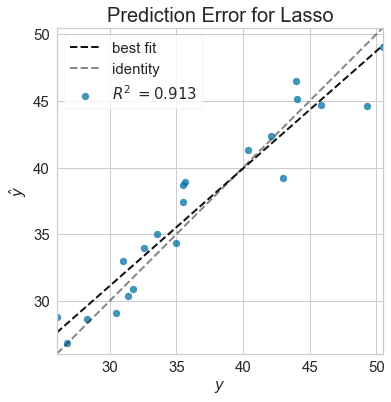

In [65]:
from yellowbrick.regressor import PredictionError
model = Lasso(alpha=0.01, max_iter=10000, random_state=42)
visualizer = PredictionError(model)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show(); 

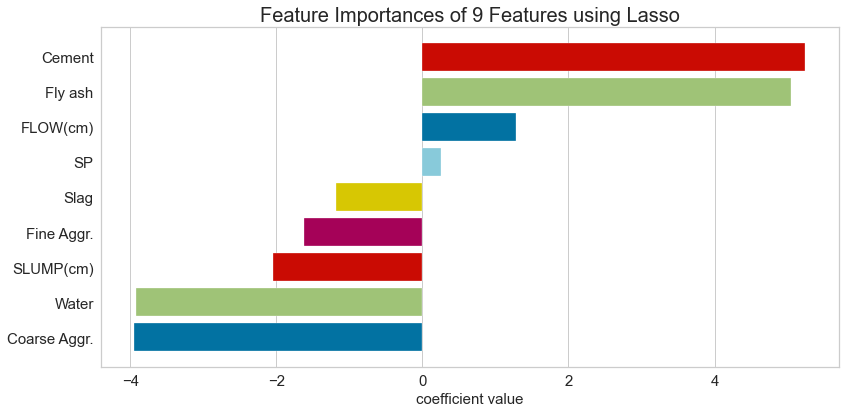

<AxesSubplot:title={'center':'Feature Importances of 9 Features using Lasso'}, xlabel='coefficient value'>

In [64]:
from yellowbrick.model_selection import FeatureImportances
model = Lasso(alpha=0.01, max_iter=1000, random_state=42)  # lasso_cv_model.alpha_ = 0.1
viz = FeatureImportances(model,labels=list(X.columns),relative=False)
viz.fit(X_train_scaled,y_train)
viz.show()

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___